# UMAP Cluster Analysis
Andrew E. Davidson  
aedavids@ucsc.edu
1/24/24

ref: intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb 


In testIntracellularLungCancerBiomarkersOnExtracellularSamples.ipynb we trained a logistic regression model using signature genes for LUAD and LUSC from /private/groups/kimlab/aedavids/deconvolution/1vsAll-~gender_category/best10CuratedDegree1_ce467ff/training/best10CuratedDegree1.sh.out/upsetPlot.out/best10_from_best500FindAllDegree1_wl500.intersection.dict

sensitivity was no not good.

In [1]:
import ipynbname

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import joblib
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', None)

import scikitplot as skplt
# from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler # LabelEncoder, 
# from sklearn.linear_model import LogisticRegression
# from sklearn.decomposition import PCA

import sys

import umap


notebookName = ipynbname.name()
notebookPath = ipynbname.path()
notebookDir = os.path.dirname(notebookPath)

#outDir = f'{notebookDir}/{notebookName}.out'
outDir = f'/private/groups/kimlab/aedavids/elife/{notebookName}.out'
os.makedirs(outDir, exist_ok=True)
print(f'outDir:\n{outDir}')

modelOutDir = os.path.join(outDir, "model")
os.makedirs(modelOutDir, exist_ok=True)
print(f'\nmodelOutDir ;\n{modelOutDir}')

imgOut = f'{outDir}/img'
os.makedirs(imgOut, exist_ok=True)
print(f'\nimgOut :\n{imgOut}')

/data/tmp/ipykernel_2587837/39016061.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/private/home/aedavids/miniconda3/envs/extraCellularRNA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


outDir:
/private/groups/kimlab/aedavids/elife/lungCancerUMAP_ClusterAnalysis.out

modelOutDir ;
/private/groups/kimlab/aedavids/elife/lungCancerUMAP_ClusterAnalysis.out/model

imgOut :
/private/groups/kimlab/aedavids/elife/lungCancerUMAP_ClusterAnalysis.out/img


In [2]:
# setting the python path allows us to run python scripts from using
# the CLI. 
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

deconvolutionModules = notebookPath.parent.joinpath("../../../../deconvolutionAnalysis/python/")
print("deconvolutionModules: {}\n".format(deconvolutionModules))

PYTHONPATH = ORIG_PYTHONPATH + f':{deconvolutionModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

intraExtraRNA_POCModules=notebookPath.parent.joinpath("../../../python/src")
print("intraExtraRNA_POCModules: {}\n".format(intraExtraRNA_POCModules))

PYTHONPATH = PYTHONPATH + f':{intraExtraRNA_POCModules}'
print("PYTHONPATH: {}\n".format(PYTHONPATH))

os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}\n".format(PYTHONPATH))

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append( str(deconvolutionModules) )
sys.path.append( str(intraExtraRNA_POCModules) )
print("\nsys.path:\n{}\n".format(sys.path))

deconvolutionModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python

intraExtraRNA_POCModules: /private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../python/src

PYTHONPATH: :/private/home/aedavids/extraCellularRNA/src:/private/home/aedavids/extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/elife/lungCancer/../../../../deconvolutionAnalysis/python:/private/home/aedavid

In [3]:
from analysis.utilities import findSignatureGenesForPipelineStage #loadDictionary, loadPipelineStageIntersectionDict
from plots.scatterPlots import createScatterPlot
from intraExtraRNA.elifeUtilities import loadCounts, loadMetaData, selectFeatures
from intraExtraRNA.utilities import selectSamples # load, 

# load elife data

In [4]:
countDF = loadCounts()
print( f'countDF.shape : {countDF.shape}')
display( countDF.head().iloc[0:4, 0:4] )

countDF.shape : (224, 76555)


gene,(A)n,(AAA)n,(AAAAAAC)n,(AAAAAAG)n
SRR14506659,201.672053,0.0,0.0,0.0
SRR14506660,110.450773,0.0,0.0,0.0
SRR14506661,3722.776395,0.0,0.0,0.0
SRR14506662,1394.605651,0.0,0.0,0.0


In [5]:
metaDF = loadMetaData()
print( f'metaDF.shape : {metaDF.shape}')
display(metaDF.head())
allCategoriesDF = metaDF.groupby('diagnosis').count()
display(allCategoriesDF)

allKinds = allCategoriesDF.index.values
print(f'\nallKinds: {allKinds}')

metaDF.shape : (224, 2)


,sample_id,diagnosis
0,SRR14506659,Esophagus Cancer
1,SRR14506660,Esophagus Cancer
2,SRR14506661,Esophagus Cancer
3,SRR14506662,Esophagus Cancer
4,SRR14506663,Esophagus Cancer


,sample_id
diagnosis,
Colorectal Cancer,53
Esophagus Cancer,31
Healthy donor,43
Liver Cancer,26
Lung Cancer,35
Stomach Cancer,36



allKinds: ['Colorectal Cancer' 'Esophagus Cancer' 'Healthy donor' 'Liver Cancer'
 'Lung Cancer' 'Stomach Cancer']


# Cluster Plots
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
https://scikit-plot.readthedocs.io/en/stable/decomposition.html#scikitplot.decomposition.plot_pca_2d_projection

## Plot all

In [6]:
def runUMAP(XNP : np.array) -> np.array:
    '''
    TODO
    '''
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    #XScaledNP=  StandardScaler().fit_transform(XNP)
    XScaledNP = MinMaxScaler().fit_transform(XNP)
    print(f'XScaledNP.shape {XScaledNP.shape}')
    
    #transFormInputNP = XNP
    transFormInputNP = XScaledNP
    
    # pca = PCA(n_components=2, random_state=42)
    # principalComponentsNP = pca.fit_transform(transFormInputNP)
    # print(f'principalComponentsNP.shape {principalComponentsNP.shape}')
    # print(principalComponentsNP[:,0])
    # print(principalComponentsNP[:,1])

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(XScaledNP)
    print(f'embedding.shape : {embedding.shape}')
    
    return embedding

In [7]:
def removeOutLiers(principalComponents : np.array, categories : list[str]) -> pd.DataFrame:
    hackDF = pd.DataFrame({
                            "x" : principalComponents[:,0], 
                            "y" : principalComponents[:,1], 
                             "category" : categories
    })
    
    hackStatsDF = hackDF.describe(percentiles=[0.01, 0.05, .25, .5, .75, 0.95, 0.99])
    display(hackStatsDF)
    
    print()
    
    # upperXThreshold, upperYThreshold = hackStatsDF.loc['95%', :].tolist()
    upperXThreshold, upperYThreshold = hackStatsDF.loc['99%', :].tolist()
    print(f'upperXThreshold : {upperXThreshold} upperYThreshold : {upperYThreshold} \n')
    
    # lowerXThreshold, lowerYThreshold = hackStatsDF.loc['5%', :].tolist()
    lowerXThreshold, lowerYThreshold = hackStatsDF.loc['1%', :].tolist()
    print(f'lowerXThreshold : {lowerXThreshold} lowerYThreshold : {lowerYThreshold} \n')
    
    selectXRows = (hackDF.loc[:, "x"] >= lowerXThreshold) &  (hackDF.loc[:, "x"] <= upperXThreshold)
    selectYRows = (hackDF.loc[:, "y"] >= lowerYThreshold) &  (hackDF.loc[:, "y"] <= upperYThreshold)
    selectRows = selectXRows & selectYRows
    print(f'sum(selectXRows) : {sum(selectXRows)} sum(selectYRows) : {sum(selectYRows)} sum(selectRows) : {sum(selectRows)}') 

    retDF = hackDF.loc[selectRows, :]
    return retDF

# noOutliersDF = removeOutLiers( principalComponentsNP, conditionList )
# print(f'noOutliersDF.shape : {noOutliersDF.shape}')

tmpMetaDF.shape : (224, 2)
allXDF.shape : (224, 76555)
mergedDF.shape : (224, 76557)
allXNP.shape : (224, 76555)
XScaledNP.shape (224, 76555)
embedding.shape : (224, 2)
embeddingNP.shape (224, 2) mergedCategories.shape (224,)


,x,y
count,224.000000,224.000000
mean,5.742726,12.023115
std,2.087380,1.027559
min,2.279091,9.702394
1%,2.495984,9.856625
5%,2.812878,10.291684
25%,4.015433,11.271401
50%,5.333171,12.134089
75%,7.909175,12.734860
95%,9.100716,13.753134



upperXThreshold : 9.362800245285035 upperYThreshold : 14.187641572952272 

lowerXThreshold : 2.495983717441559 lowerYThreshold : 9.856625299453736 

sum(selectXRows) : 218 sum(selectYRows) : 218 sum(selectRows) : 212
xmin: 2.5004196166992188 xMax : 9.357939720153809
yMin: 9.892057418823242 yMax : 14.12890625
df.shape : (212, 3)
saved image to /private/groups/kimlab/aedavids/elife/lungCancerUMAP_ClusterAnalysis.out/img/allElifeUMAP.png


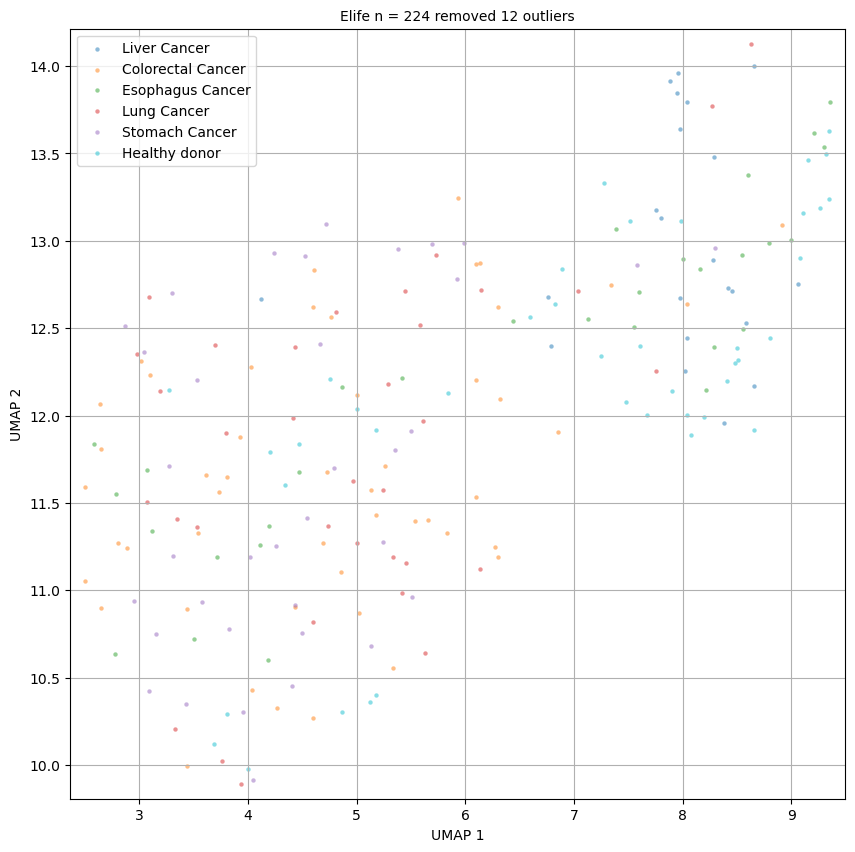

In [8]:
def plotAll(countDF, metaDF, allKinds, imgOut):
    '''
    TODO
    '''

    tmpMetaDF = metaDF.rename( columns={ "diagnosis" : "category"} )
    print(f'tmpMetaDF.shape : {tmpMetaDF.shape}')
    
    allXDF = selectSamples(tmpMetaDF, countDF, allKinds)
    print(f'allXDF.shape : {allXDF.shape}')

    # inner join on index
    # will have two extra cols 'sample_id', 'category'
    mergedDF = pd.merge(allXDF, tmpMetaDF, left_index=True, right_on='sample_id', how='inner')
    print(f'mergedDF.shape : {mergedDF.shape}')
    
    allXNP = mergedDF[ mergedDF.columns.difference(['sample_id', 'category']) ].values
    print(f'allXNP.shape : {allXNP.shape}')

    embeddingNP = runUMAP(allXNP)
    
    mergedCategories = mergedDF.loc[:, 'category'].values 
    print(f'embeddingNP.shape {embeddingNP.shape } mergedCategories.shape {mergedCategories.shape}')
    noOutliersDF = removeOutLiers( embeddingNP, mergedCategories)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:cyan']
    assert len(colors) == len(allKinds), f'ERROR len(colors) : {len(colors)} != len(allKinds): {len(allKinds)}'
    fig, pannel = createScatterPlot(
        # x = principalComponentsNP[:,0],
        # y = principalComponentsNP[:,1],
        x = noOutliersDF.loc[:, "x"].values,
        y = noOutliersDF.loc[:, "y"].values,
        #title = 'Elife n = 78 are not separable',
        title = f'Elife n = {embeddingNP.shape[0]} removed {embeddingNP.shape[0]- noOutliersDF.shape[0]} outliers',
        # title = f'Elife n = {principalComponentsNP.shape[0]}',
        xLabel = 'UMAP 1',
        yLabel = 'UMAP 2', 
        categories = noOutliersDF.loc[:, "category"].values,
        # colors  = ['r',  'b'],
        colors = colors,
        #figSize = (4,4), 
        figSize = (10,10), 
        #figSize = (15,15), 
        axisPaddingPrecentage = 0.02,
        #axisPaddingPrecentage = -0.01, # may clip some outliers
    )
    
    imgFilePath = imgOut + "/allElifeUMAP.png"
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

plotAll(countDF, metaDF, allKinds, imgOut)

## Lung vs Healthy Donor

XDF.shape : (78, 76555)
mergedDF.shape : (78, 76557)
XNP.shape : (78, 76555)
XScaledNP.shape (78, 76555)
embedding.shape : (78, 2)


,x,y
count,78.000000,78.000000
mean,13.965919,0.362988
std,1.339122,1.291164
min,11.854932,-2.187639
1%,11.870332,-2.078011
5%,11.996907,-1.741200
25%,12.674527,-0.643823
50%,14.008639,0.322071
75%,15.066057,1.461017
95%,16.070930,2.292385



upperXThreshold : 16.333169803619384 upperYThreshold : 2.5951655459403993 

lowerXThreshold : 11.87033218383789 lowerYThreshold : -2.078010547161102 

sum(selectXRows) : 76 sum(selectYRows) : 76 sum(selectRows) : 74
noOutliersDF.shape : (74, 3)
xmin: 11.874932289123535 xMax : 16.285181045532227
yMin: -2.04526424407959 yMax : 2.5771188735961914
df.shape : (74, 3)
saved image to /private/groups/kimlab/aedavids/elife/lungCancerUMAP_ClusterAnalysis.out/img/allElifeLungUMAP.png


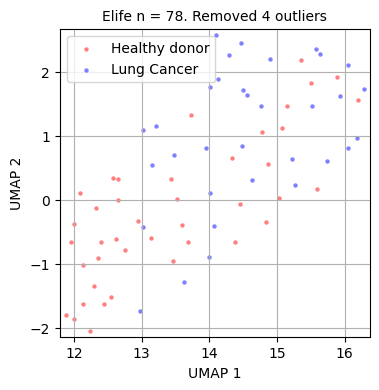

In [9]:
def plotLung(countDF, metaDF, imgOut):
    # select lung and healthy donnor sample
    listOfCategories = ["Healthy donor", "Lung Cancer"]
    tmpMetaDF = metaDF.rename( columns={ "diagnosis" : "category"} )
    # display( tmpMetaDF.head() )
    XDF = selectSamples(tmpMetaDF, countDF, listOfCategories)
    print(f'XDF.shape : {XDF.shape}')
    
    # inner join on index
    # will have two extra cols 'sample_id', 'category'
    mergedDF = pd.merge(XDF, tmpMetaDF, left_index=True, right_on='sample_id', how='inner')
    print(f'mergedDF.shape : {mergedDF.shape}')

    XNP = mergedDF[ mergedDF.columns.difference(['sample_id', 'category']) ].values
    print(f'XNP.shape : {XNP.shape}')

    mergedCategories = mergedDF.loc[:, 'category'].values 
    
    embeddingNP = runUMAP(XNP)
    
    noOutliersDF = removeOutLiers( embeddingNP, mergedCategories )
    print(f'noOutliersDF.shape : {noOutliersDF.shape}')
    
    fig, pannel = createScatterPlot(
            # x = principalComponentsNP[:,0],
            # y = principalComponentsNP[:,1],
            x = noOutliersDF.loc[:, "x"].values,
            y = noOutliersDF.loc[:, "y"].values,
            #title = 'Elife n = 78 are not separable',
            title = f'Elife n = {embeddingNP.shape[0]}. Removed {embeddingNP.shape[0]- noOutliersDF.shape[0]} outliers',
            xLabel = 'UMAP 1',
            yLabel = 'UMAP 2', 
            categories = noOutliersDF.loc[:, "category"].values,
            colors  = ['r',  'b'],
            figSize = (4,4), 
            # figSize = (10,10), 
            #figSize = (15,15), 
            axisPaddingPrecentage = 0.02,
            #axisPaddingPrecentage = -0.01, # may clip some outliers
    )

    imgFilePath = imgOut + "/allElifeLungUMAP.png"
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

plotLung(countDF, metaDF, imgOut)

## Does clustering using on LUAD, LUSC, and Lung Intracelluar biomarkers work?
select biomarkers and remove missing genes

In [10]:
LUADGenes = findSignatureGenesForPipelineStage(category="LUAD", pipelineStageName="best10CuratedDegree1_ce467ff")
print(f'LUAD genes:\n{LUADGenes}')

LUSCGenes = findSignatureGenesForPipelineStage(category="LUSC", pipelineStageName="best10CuratedDegree1_ce467ff")
print(f'\nLUSC genes:\n{LUSCGenes}')

# Lung is our healthy control
controlGenes = findSignatureGenesForPipelineStage(category="Lung", pipelineStageName="best10CuratedDegree1_ce467ff")
print(f'\n healthy control Lung genes:\n{controlGenes}')

HUGO_lungGenes = LUADGenes + LUSCGenes + controlGenes
print(f'len(HUGO_lungGenes) {len(HUGO_lungGenes)}')

LUAD genes:
['AC011944.1', 'ATP13A4-AS1', 'AC090004.1', 'GXYLT1P3', 'AC126323.6', 'AC111149.2', 'AL365181.4', '(TCCAC)n', 'BPIFA2', 'IGHJ5']

LUSC genes:
['FMO6P', 'AC121493.1', 'AP001120.2', 'LINC01249', 'AP000344.1', '(TCTATG)n', 'AC092140.2', 'AP001360.1', 'ENPP7P11', 'AC018521.2']

 healthy control Lung genes:
['FPR3', 'CSF3', 'SLAMF8', 'ENTPD2', 'MAGEE1', 'PCAT19', 'GRIP2', 'PTGIR', 'RND1', 'CHRNB1']
len(HUGO_lungGenes) 30


In [11]:
%%time
elifeLungGenes, missingElifeGenes = selectFeatures(countDF, HUGO_lungGenes)
print( f'len(elifeLungGenes) : {len(elifeLungGenes)}' )
print( f'missingElifeGenes\n : {missingElifeGenes}' )

# remove missing biomarkers
features = list( set(elifeLungGenes) - set(missingElifeGenes) )
assert len(features) == 29, "ERROR removing missing elife genes"

refSeq2ENSGDF.loc[selectRows, :] :
              HUGO               ENSG bioType
97713   AC111149.2  ENSG00000253339.2  lncRNA
172016  AC092140.2  ENSG00000274031.1  lncRNA
203145      PCAT19  ENSG00000267107.8  lncRNA
len(elifeLungGenes) : 30
missingElifeGenes
 : ['ENSG00000274031.1']
CPU times: user 28.5 s, sys: 4.06 s, total: 32.5 s
Wall time: 33 s


XDF.shape : (78, 29)
mergedDF.shape : (78, 31)
XNP.shape : (78, 29)
XScaledNP.shape (78, 29)
embedding.shape : (78, 2)


,x,y
count,78.000000,78.000000
mean,-8.291158,6.289820
std,1.184513,1.237542
min,-10.180225,4.162663
1%,-10.073284,4.185273
5%,-9.913728,4.508877
25%,-9.415915,5.200498
50%,-8.424716,6.256203
75%,-7.434260,7.405497
95%,-6.288952,8.154267



upperXThreshold : -6.089442148208618 upperYThreshold : 8.55921157836914 

lowerXThreshold : -10.073284273147584 lowerYThreshold : 4.185272722244263 

sum(selectXRows) : 76 sum(selectYRows) : 76 sum(selectRows) : 74
noOutliersDF.shape : (74, 3)
xmin: -10.041340827941895 xMax : -6.112518787384033
yMin: 4.192026138305664 yMax : 8.553046226501465
df.shape : (74, 3)
saved image to /private/groups/kimlab/aedavids/elife/lungCancerUMAP_ClusterAnalysis.out/img/elifeHealthy_LungCancerUMAP.png


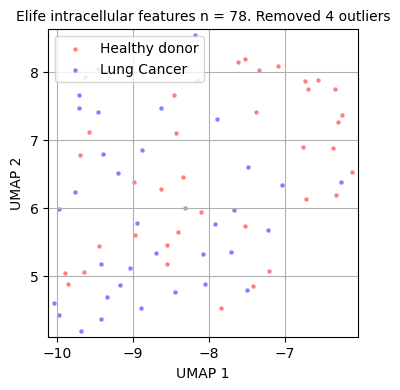

In [12]:
def plotLungIntracellularBiomarkersOnElifePlasma(countDF, metaDataDF, features):
    '''
    TODO
    '''
    listOfCategories = ["Healthy donor", "Lung Cancer"]
    tmpMetaDF = metaDF.rename( columns={ "diagnosis" : "category"} )
    # display( tmpMetaDF.head() )
    XDF = selectSamples(tmpMetaDF, countDF, listOfCategories)
    XDF = XDF.loc[:, features]

    print(f'XDF.shape : {XDF.shape}')

       # inner join on index
    # will have two extra cols 'sample_id', 'category'
    mergedDF = pd.merge(XDF, tmpMetaDF, left_index=True, right_on='sample_id', how='inner')
    print(f'mergedDF.shape : {mergedDF.shape}')

    XNP = mergedDF[ mergedDF.columns.difference(['sample_id', 'category']) ].values
    print(f'XNP.shape : {XNP.shape}')

    mergedCategories = mergedDF.loc[:, 'category'].values 
    
    embeddingNP = runUMAP(XNP)

    noOutliersDF = removeOutLiers( embeddingNP, mergedCategories )
    print(f'noOutliersDF.shape : {noOutliersDF.shape}')
    
    fig, pannel = createScatterPlot(
            # x = principalComponentsNP[:,0],
            # y = principalComponentsNP[:,1],
            x = noOutliersDF.loc[:, "x"].values,
            y = noOutliersDF.loc[:, "y"].values,
            #title = 'Elife n = 78 are not separable',
            title = f'Elife intracellular features n = {embeddingNP.shape[0]}. Removed {embeddingNP.shape[0]- noOutliersDF.shape[0]} outliers',
            xLabel = 'UMAP 1',
            yLabel = 'UMAP 2', 
            categories = noOutliersDF.loc[:, "category"].values,
            colors  = ['r',  'b'],
            figSize = (4,4), 
            # figSize = (10,10), 
            #figSize = (15,15), 
            axisPaddingPrecentage = 0.02,
            #axisPaddingPrecentage = -0.01, # may clip some outliers
    )

    imgFilePath = imgOut + "/elifeHealthy_LungCancerUMAP.png"
    fig.savefig(imgFilePath, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)
    print(f'saved image to {imgFilePath}')

plotLungIntracellularBiomarkersOnElifePlasma(countDF, metaDF, features)